In [344]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Dropout, LeakyReLU, Reshape, Bidirectional, LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import concatenate, Conv1D, BatchNormalization, Flatten, Multiply, Concatenate, Add, Subtract, Dot, Lambda, PReLU, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor

In [345]:
BATCH_SIZE = 32
EPOCKS = 50
CLASSES = 9
POINTS = 5
FEATURES_SENSOR = 3
FEATURES = POINTS * FEATURES_SENSOR

In [346]:
def load_data():
    path = '../input/mousey/'
    gens = None
    paths = os.listdir(path)
    for p in paths:
        p = path +'/'+ p
        for file in os.listdir(p):
            gen = pd.read_csv(p + '/' +file)
            if gens is None:
                gens = gen
            else:
                gens = pd.concat([gens, gen])
    return gens

gens = load_data()
gens.head()

,Unnamed: 0,tag,accelometer_x,accelometer_y,accelometer_z,gyroscope_x,gyroscope_y,gyroscope_z,speed
0,0,up,-0.105348,1.652050,9.663293,0.000896,0.010433,-0.218299,NaN
1,1,up,-0.339987,1.948940,9.684841,0.001507,0.002492,-0.106511,NaN
2,2,up,0.217879,1.546702,9.668081,0.001507,-0.010336,0.030934,NaN
3,3,up,-0.656031,2.291321,9.845258,-0.002158,0.000048,0.143944,NaN
4,4,up,-0.608146,1.960911,9.708784,-0.000936,-0.003006,0.153107,NaN


In [347]:
def analyze_tags(gens):
    tags = gens['tag'].unique()
    print('tags (', len(tags) ,'): ', tags)
    grouped = gens.groupby('tag').count()

analyze_tags(gens)

tags ( 9 ):  ['up' 'down' 'right' 'left' 'upright' 'downleft' 'upleft' 'downright'
 'ned']


In [348]:
def create_X_y(gens):
    X = gens.drop(['tag','speed','Unnamed: 0'], axis=1)
    y = gens['tag']
    return X, y

X, y = create_X_y(gens)

In [397]:
def split_train_test(X, y, precentage = 0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=precentage)
    print('X train shape: ',X_train.shape, ' y train shape: ', y_train.shape)
    print('X test shape: ',X_test.shape, ' y test shape: ', y_test.shape)
    return X_train, X_test, y_train, y_test

def y_to_categorical(y_train, y_test):
    dic = {x:i for i,x in enumerate(y_train.unique())}
    names = [x for x in y_train.unique()]
    len_train = len(y_train)
    y = np.concatenate([y_train.to_numpy(), y_test.to_numpy()])
    y = [dic[x] for x in y]
    y = to_categorical(y)
    y_train = y[0:len_train]
    y_test = [dic[x] for x in y_test]
    print('Changed to catigorical','y train shape: ',len(y_train), ' y test shape: ', len(y_test))
    return y_train, y_test, dic, names

In [350]:
def split_train_test_by_sliding_window(X,y, N=2):
    grouped = gens.groupby('tag')
    X_tmp = None
    X_original = None
    y_original = None
    start = N
    end = None
    for g in grouped:
        X, y = create_X_y(g[1])
        end = len(X)
        tmp_dic = {}
        if X_original is None:
            X_original = X.iloc[start:]
            y_original = y.iloc[start:]
        else:
            X_original = pd.concat([X_original,X.iloc[start:]])
            y_original = pd.concat([y_original, y.iloc[start:]])
        for col in X.columns:
            for i in range(1,N,1):
                name = 'prev_'+str(i)+'_'+col

                tmp_dic[name] = X[col].iloc[start-i: end-i].values
        if X_tmp is None:
            X_tmp = pd.DataFrame.from_dict(tmp_dic)
        else:
            X_tmp = pd.concat([X_tmp, pd.DataFrame.from_dict(tmp_dic)])
    X_original = X_original.reset_index()
    X_tmp = X_tmp.reset_index()
    X_tmp = pd.concat([X_tmp, X_original], axis=1)
    X_tmp = X_tmp.drop(['index'], axis=1)
    print('X devide: ',X_tmp.shape, ' y devide: ', y_original.shape)
    X_train, X_test, y_train, y_test = split_train_test(X_tmp, y_original)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_train_test_by_sliding_window(X, y, N=POINTS)
y_train, y_test, y_dic, y_names = y_to_categorical(y_train, y_test)

X devide:  (13025, 30)  y devide:  (13025,)
X train shape:  (10420, 30)  y train shape:  (10420,)
X test shape:  (2605, 30)  y test shape:  (2605,)
Changed to catigorical y train shape:  10420  y test shape:  2605


In [351]:
def create_callbacks(name, patience=5):
    early_stopping = EarlyStopping(patience=patience)
    cheak_point = ModelCheckpoint(name)
    return [early_stopping, cheak_point]

def create_metrics():
    return ['accuracy']

In [352]:
def quick_plot_loss(history, field, metric, ax):
    # Plot training & validation loss values
    ax.plot(history.history[field])
    ax.plot(history.history['val_'+field])
    ax.set_title('Model '+ metric)
    ax.set_ylabel(metric)
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Validation'], loc='upper left')
                
    
def quick_plot_history(history):
    fig = plt.figure(figsize=(18, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title('loss')
    quick_plot_loss(history, 'loss', 'categorical_crossentropy', ax)
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title('accrucy')
    quick_plot_loss(history, 'accuracy', 'accuracy', ax)

In [353]:
def test_results(model,X_test,y_test, LOAD=True):
    preds = model.predict(X_test)
    pred_cat = np.argmax(preds,axis=1) #takes the maximum prediction and compare it to the real prediction
    acc = accuracy_score(y_test,pred_cat)*100
    acc_saved = -1
    if LOAD:
        saved_model = load_model('./'+model.name+'.h5')
        preds = saved_model.predict(X_test)
        pred_cat = np.argmax(preds,axis=1) #takes the maximum prediction and compare it to the real prediction
        acc_saved = accuracy_score(y_test,pred_cat)*100
    if acc >= acc_saved:
        if LOAD:
            model.save('./'+model.name+'.h5')
        print('NEW: model accuracy on test set is: {0:.2f}%'.format(acc))
    else:
        print('model accuracy on test set is: {0:.2f}%'.format(acc_saved)) 

In [354]:
def sp_acc_txt(prev=None):
    if prev is None:
        return ['accelometer_x','accelometer_y','accelometer_z']
    name = 'prev_'+str(prev)+'_'
    return [name+'accelometer_x',name+'accelometer_y',name+'accelometer_z']

def split_acc(points,index=None):
    l = []
    if index is None or index != 0:
        l = sp_acc_txt()
    for i in range(1,points):
        if index is None or i != index:
            l += sp_acc_txt(prev=i)
    return l

def sp_gyro_txt(prev=None):
    if prev is None:
        return ['gyroscope_x','gyroscope_y','gyroscope_z']
    name = 'prev_'+str(prev)+'_'
    return [name+'gyroscope_x',name+'gyroscope_y',name+'gyroscope_z']

def split_gyro(points,index=None):
    l = []
    if index is None or index != 0:
        l = sp_gyro_txt()
    for i in range(1,points):
        if index is None or i != index:
            l += sp_gyro_txt(prev=i)
    return l

def split_channels(X, p=5):
    t = ()
    l = None
    acc = None
    gyto = None
    for i in range(p):
        l = split_acc(p, index=i) + split_gyro(p)
        acc = X.drop(l, axis=1)
        l = split_acc(p) + split_gyro(p, index=i)
        gyro = X.drop(l, axis=1)
        t += (acc , gyro) 
    return t

In [355]:
def dense_deapth_block(inp, N=32, extend_N=4, deapth=5):
    if deapth==0:
        return inp
    x = None 
    prev_x = None
    xs = []
    for i in range(0, deapth):
        if x is None:
            x = Dense(N)(inp)
            x = PReLU()(x)
        else:
            prev_x = x
            x = Dense(N + i*extend_N)(prev_x)
            x = PReLU()(x)
        xs.append(x)
    if len(xs) != 1:
        x = concatenate(xs)
    return x

In [356]:
def create_chanel(size=FEATURES_SENSOR, deapth=5, N=32,extend_N=16):
    inp = Input(shape=size)
    x = dense_deapth_block(inp, deapth=deapth, N=N, extend_N=extend_N)
    return inp, x

In [357]:
def create_model_channel_6_d(p=2):
    inp1, c1 = create_chanel(deapth=2,N=16)
    inp2, c2 = create_chanel(deapth=2,N=16)
    inp3, c3 = create_chanel(deapth=2,N=16)
    inp4, c4 = create_chanel(deapth=2,N=16)
    inp5, c5 = create_chanel(deapth=2,N=16)
    inp6, c6 = create_chanel(deapth=2,N=16)
    inp7, c7 = create_chanel(deapth=2,N=16)
    inp8, c8 = create_chanel(deapth=2,N=16)
    inp9, c9 = create_chanel(deapth=2,N=16)
    inp10, c10 = create_chanel(deapth=2,N=16)
    x = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10])
    x = PReLU()(x)
    x = Dense(64)(x)
    x = PReLU()(x)
    x = Dense(128)(x)
    x = Dense(CLASSES, activation='softmax')(x)
    model = Model(inputs=[inp1, inp2, inp3, inp4, inp5, inp6, inp7, inp8, inp9, inp10], outputs=x, name='model16') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model16 = create_model_channel_6_d(p=POINTS)
model16.summary()

Model: "model16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_222 (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_223 (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_224 (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_225 (InputLayer)          [(None, 3)]          0                                            
____________________________________________________________________________________________

In [358]:
callbacks = create_callbacks('model16.h5')
history = model16.fit(split_channels(X_train, p=POINTS), y_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=callbacks)

Epoch 1/200
131/131 [==============================] - 1s 11ms/step - loss: 1.7331 - accuracy: 0.3682 - val_loss: 1.1529 - val_accuracy: 0.5811
Epoch 2/200
131/131 [==============================] - 1s 7ms/step - loss: 0.9362 - accuracy: 0.6264 - val_loss: 0.8952 - val_accuracy: 0.6478
Epoch 3/200
131/131 [==============================] - 1s 6ms/step - loss: 0.7902 - accuracy: 0.6700 - val_loss: 0.7939 - val_accuracy: 0.6622
Epoch 4/200
131/131 [==============================] - 1s 7ms/step - loss: 0.7376 - accuracy: 0.6984 - val_loss: 0.7858 - val_accuracy: 0.6655
Epoch 5/200
131/131 [==============================] - 1s 7ms/step - loss: 0.7137 - accuracy: 0.7007 - val_loss: 0.7107 - val_accuracy: 0.7039
Epoch 6/200
131/131 [==============================] - 1s 7ms/step - loss: 0.6754 - accuracy: 0.7144 - val_loss: 0.7190 - val_accuracy: 0.7049
Epoch 7/200
131/131 [==============================] - 1s 7ms/step - loss: 0.6595 - accuracy: 0.7234 - val_loss: 0.7436 - val_accuracy: 0.708

NEW: model accuracy on test set is: 76.43%


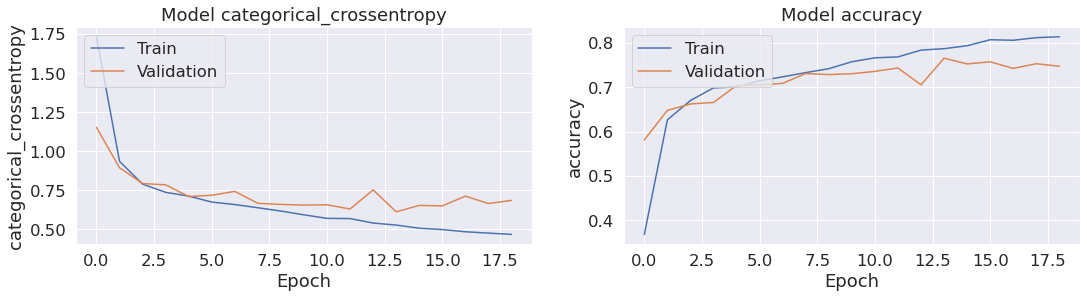

In [359]:
quick_plot_history(history)
test_results(model16, split_channels(X_test, p=POINTS), y_test)

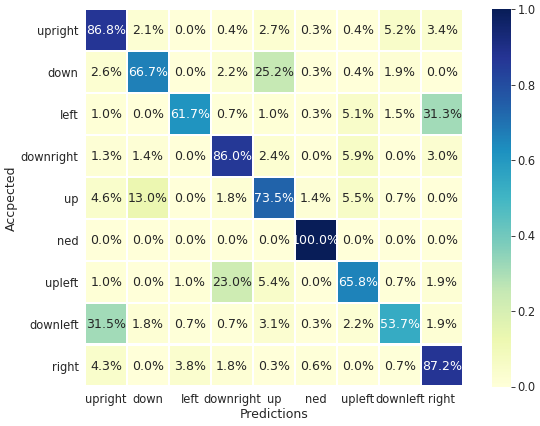

In [360]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, preds):
    con = confusion_matrix(y_test, preds)
    con = con / np.sum(con, axis=1)
    plt.figure(figsize=(15,10), dpi=50)
    sns.set(font_scale=1.5)
    sns.heatmap(con, xticklabels = y_names, yticklabels = y_names, linewidths=2, annot=True, fmt = '.1%',cmap="YlGnBu",square=True)
    plt.xlabel('Predictions')
    plt.ylabel('Accpected')

preds = model16.predict(split_channels(X_test, p=POINTS))
preds = np.argmax(preds,axis=1)
plot_confusion_matrix(y_test, preds)

In [435]:
def y_to_vx(y):
    if y == 'up' or y =='down' or y=='ned':
        return 'ned'
    elif y =='right' or y =='upright' or y =='downright':
        return 'right'
    elif y =='left' or y =='downleft' or y =='upleft':
        return 'left'
    return 'error'
    
def y_to_vy(y):
    speed = 3
    if y == 'up' or y=='upright' or y =='upleft': 
        return 'up'
    elif y =='down' or y =='downleft' or y =='downright':
        return 'down'
    elif y =='right' or y =='left' or y=='ned':
        return 'ned'
    return 'error'

def y_to_vector(train, test):
    y_train ={}
    y_test ={}
    
    y_train['vx'] = [y_to_vx(y) for y in train]
    y_train['vy'] = [y_to_vy(y) for y in train]
    y_train = pd.DataFrame.from_dict(y_train)
    
    y_test['vx'] = [y_to_vx(y) for y in test]
    y_test['vy'] = [y_to_vy(y) for y in test]
    y_test = pd.DataFrame.from_dict(y_test)
    
    vx_train, vx_test, vx_dic, vx_names = y_to_categorical(y_train['vx'], y_test['vx'])
    vy_train, vy_test, vy_dic, vy_names = y_to_categorical(y_train['vy'], y_test['vy'])

    return vx_train, vx_test, vx_names, vy_train, vy_test, vy_names


In [436]:
X_train, X_test, y_train, y_test = split_train_test_by_sliding_window(X, y, N=POINTS)
vx_train, vx_test, vx_names, vy_train, vy_test, vy_names = y_to_vector(y_train, y_test)

X devide:  (13025, 30)  y devide:  (13025,)
X train shape:  (10420, 30)  y train shape:  (10420,)
X test shape:  (2605, 30)  y test shape:  (2605,)
Changed to catigorical y train shape:  10420  y test shape:  2605
Changed to catigorical y train shape:  10420  y test shape:  2605
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [437]:
def create_model_17(p=2):
    inp1, c1 = create_chanel(deapth=2,N=16)
    inp2, c2 = create_chanel(deapth=2,N=16)
    inp3, c3 = create_chanel(deapth=2,N=16)
    inp4, c4 = create_chanel(deapth=2,N=16)
    inp5, c5 = create_chanel(deapth=2,N=16)
    inp6, c6 = create_chanel(deapth=2,N=16)
    inp7, c7 = create_chanel(deapth=2,N=16)
    inp8, c8 = create_chanel(deapth=2,N=16)
    inp9, c9 = create_chanel(deapth=2,N=16)
    inp10, c10 = create_chanel(deapth=2,N=16)
    vx = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10])
    vx = PReLU()(vx)
    vx = Dense(64)(vx)
    vx = PReLU()(vx)
    vx = Dense(128)(vx)
    vx = Dense(3, activation='softmax')(vx)
    
    vy = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10])
    vy = PReLU()(vy)
    vy = Dense(64)(vy)
    vy = PReLU()(vy)
    vy = Dense(128)(vy)
    vy = Dense(3, activation='softmax')(vy)
    
    model = Model(inputs=[inp1, inp2, inp3, inp4, inp5, inp6, inp7, inp8, inp9, inp10], outputs=[vx, vy], name='model17') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model17 = create_model_17(p=POINTS)
model17.summary()

Model: "model16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_222 (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_223 (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_224 (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_225 (InputLayer)          [(None, 3)]          0                                            
____________________________________________________________________________________________

In [ ]:
callbacks = create_callbacks('model17.h5')
history = model17.fit(split_channels(X_train, p=POINTS), [vx_train, vy_train], epochs=200, batch_size=64, validation_split=0.2, callbacks=callbacks)